In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import json
from datetime import datetime
from tqdm import tqdm
from pprint import pprint
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# training and Testing directories
training_dir = os.path.join("Datasets", "Training")
testing_dir = os.path.join("Datasets", "Testing")
if not os.path.isdir(training_dir):
    raise Exception("ERROR: training dataset not found")
if not os.path.isdir(testing_dir):
    raise Exception("ERROR: testing dataset not found")

## Part 1: Analyzing the data

Size/RAM experiments: loading all training as lists requires approximately 10.3 GB of RAM. It is suggested to only extract the features you need each time

In [5]:
# iterate over all hashtag files 
for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        print(os.path.join(root, file))

Datasets\Training\tweets_#gohawks.txt
Datasets\Training\tweets_#gopatriots.txt
Datasets\Training\tweets_#nfl.txt
Datasets\Training\tweets_#patriots.txt
Datasets\Training\tweets_#sb49.txt
Datasets\Training\tweets_#superbowl.txt


##### Question 1: Get statistics

In [6]:
# iterate over all hashtag files 
for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        filename = os.path.splitext(file)[0].replace('tweets_#', '')
        print('Parsing {}...'.format(filename))
        
        # only extracting specific features from the tweet json objects
        citation_dates = []
        followers = []
        retweets = []
        
        # open the file and read all lines:
        with open(os.path.join(root, file), "r", encoding="utf-8") as hashtag:
            # read line-by-line
            for line in hashtag:
                json_obj = json.loads(line)
                
                # get citation date
                citation_date = json_obj['citation_date']
                citation_dates.append(citation_date)
                
                # get number of followers for the author of eath tweet
                follower_count = json_obj['author']['followers']
                followers.append(follower_count)
                
                # get retweets
                retweet_total = json_obj['metrics']['citations']['total']
                retweets.append(retweet_total)
        
        # processing citation feature
        print('\t'+'-'*10)
        citation_dates = np.array(citation_dates)
        print('\tnumber of tweets in period: {}'.format(len(citation_dates)))
        min_date = np.min(citation_dates)
        max_date = np.max(citation_dates)
        
        span_hours = (max_date - min_date)/60
        print('\tnumber of hours in period: {}'.format(span_hours))
        
        tweets_per_hour = len(citation_dates) / span_hours
        print('\taverage tweets per hour: {}'.format(tweets_per_hour))
        
        # processing followers feature
        print('\t'+'-'*10)
        followers = np.array(followers)
        follower_avg = np.average(followers)
        print('\taverage followers per tweeter: {}'.format(follower_avg))
        
        # processing retweets feature
        print('\t'+'-'*10)
        retweets = np.array(retweets)
        retweet_avg = np.average(retweets)
        print('\taverage retweets per tweet: {}'.format(retweet_avg))
        
        print('\t'+'-'*10)
        print('')

Parsing gohawks...
{'author': {'author_img': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
            'description': 'Married to my best friend... You-make me laugh and '
                           'occasionally think... I-will let you in on some of '
                           'the crazy shit that consumes my thoughts...',
            'followers': 1752.0,
            'image_url': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
            'name': 'RJ',
            'nick': 'rejinseattle',
            'type': 'twitter',
            'url': 'http://twitter.com/rejinseattle'},
 'citation_date': 1421518778,
 'citation_url': 'http://twitter.com/REJinseattle/status/556516209261166593',
 'firstpost_date': 1419804875,
 'highlight': 'I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8',
 'metrics': {'acceleration': 0,
             'citations': {'data': [{'citations': 1, 'timestamp': 1421518739}],
                           'influe

ValueError: zero-size array to reduction operation minimum which has no identity

##### Question 2: Number of tweets every hour

Parsing nfl...


100%|██████████| 233022/233022 [00:19<00:00, 12221.68it/s]


1421222404
2015-01-14 00:00:04


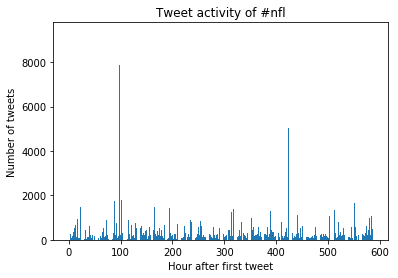

Parsing superbowl...


100%|██████████| 1213813/1213813 [01:32<00:00, 13143.80it/s]


1421223187
2015-01-14 00:13:07


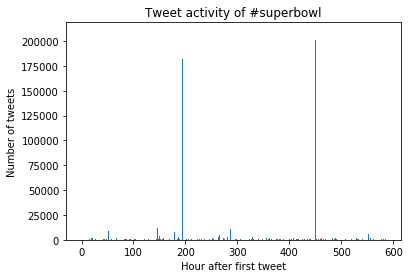

In [8]:
only_parse = ['superbowl', 'nfl']
file_lengths = {
    'superbowl': 1213813,
    'nfl': 233022
}

# iterate over all hashtag files 
for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        filename = os.path.splitext(file)[0].replace('tweets_#', '')
        
        if not filename in only_parse:
            # skip if not focussed on this hashtag
            continue
            
        print('Parsing {}...'.format(filename))
        
        # only extracting specific features from the tweet json objects
        citation_dates = []
        
        # open the file and read all lines:
        with open(os.path.join(root, file), "r", encoding="utf-8") as hashtag:
            # read line-by-line
            for line in tqdm(hashtag, total=file_lengths[filename]):
                json_obj = json.loads(line)
                
                # get citation date
                citation_date = json_obj['citation_date']
                citation_dates.append(citation_date)
        
        # processing citation feature
        citation_dates = np.array(citation_dates)
        min_date = np.min(citation_dates)
        max_date = np.max(citation_dates)
        print(min_date)
        print(datetime.fromtimestamp(min_date))
        
        # get the bins we need
        bins = {}
        while min_date < max_date:
            tweets_in_bin = 0
            for citation_date in citation_dates:
                if min_date < citation_date < min_date + 3600:
                    tweets_in_bin += 1
                    
            # add tweets_in_bin to bins, with key being the min_date
            bins[min_date] = tweets_in_bin
            
            # increment min_date by an hour
            min_date += 3600
            
#         print(bins)
#         print('-'*10)

        # plot a bar plot of the bins
        plt.title('Tweet activity of #{}'.format(filename))
        plt.ylabel('Number of tweets')
        plt.xlabel('Hour after first tweet')
        plt.ylim(0, np.max(np.array(list(bins.values()))))
        plt.bar(np.arange(len(bins.keys())), list(bins.values()))
        plt.show()